### Import packages and Connect to WRDS

In [2]:
pip install wrds

Note: you may need to restart the kernel to use updated packages.


In [167]:
# Import packages
import pandas as pd
import numpy as np
import wrds
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [105]:
# Connect to WRDS
db = wrds.Connection()

Enter your WRDS username [anthony_ning]: dr1902
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  n


You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


### Retrive daily prices for specific companies using 'permno' and daily sp500 market index

In [204]:
# Read sp500_test_2.csv
data = pd.read_csv('sp500_test_2.csv')
perms = data['permno']

In [107]:
# Query CRSP Daily Stock File for daily returns of specific companies
query_returns = f"""
SELECT date, permno, prc
FROM crsp.dsf
WHERE permno IN ({','.join([f"'{perm}'" for perm in perms])})
AND date BETWEEN '2023-12-01' AND '2023-12-31'
ORDER BY permno, date
"""

# Execute the query
daily_returns = db.raw_sql(query_returns)

daily_returns['date'] = pd.to_datetime(daily_returns['date'])

In [108]:
# Retrieve daily value-weighted market returns (with dividends) and sp500 market index
query = """
SELECT date, spindx, vwretd
FROM crsp.dsi
WHERE date BETWEEN '2023-12-01' AND '2023-12-31'
"""

# Execute the query
vw_market_daily = db.raw_sql(query)

vw_market_daily['date'] = pd.to_datetime(vw_market_daily['date'])

In [170]:
daily_returns

,date,permno,prc
0,2023-12-01,10104,117.16000
1,2023-12-04,10104,115.78000
2,2023-12-05,10104,114.53000
3,2023-12-06,10104,112.03000
4,2023-12-07,10104,112.87000
...,...,...,...
555,2023-12-22,93096,132.21001
556,2023-12-26,93096,133.06000
557,2023-12-27,93096,134.44000
558,2023-12-28,93096,135.55000


### Sum up weights for each 10-K and 10-Q file

In [187]:
tf_weight = np.sum(pd.read_csv('sp_testfile_weight.csv', index_col=0), axis=0)
pro_weight = np.sum(pd.read_csv('sp_testfile_proweight.csv', index_col=0), axis=0)

In [201]:
data_order = []
for index in tf_weight.index:
    data_order.append((index[6:-9], index[12:16]))

### Calculate 4-day excess return

In [137]:
# The function is used to get the stock price and the sp500 market index after at least 4 days
def get_price_end(index, perm, date):
    while (daily_returns['permno'].loc[index]==perm) & (daily_returns['date'].loc[index]-date < pd.Timedelta(4, 'd')):
        index += 1
    return daily_returns['prc'].loc[index], vw_market_daily.loc[vw_market_daily.date==daily_returns['date'].loc[index]]['spindx']

In [225]:
# Get the excess return holding for four days starting from the 10k or 10q filed date
bh_excess_ret = []

for data_info in data_order:
    perm = int(data_info[0])
    f_type = data_info[1]
    
    date = data.loc[(data.permno==perm) & (data.form_type==f_type)]['filed_date']
    date = pd.Timestamp(date.values[0])
    
    price = daily_returns.loc[(daily_returns.date==date) & (daily_returns.permno==perm)]['prc']
    price = price.values[0]
    m_price = vw_market_daily.loc[vw_market_daily.date==date]['spindx']
    m_price = m_price.values[0]
    
    start_index = daily_returns.loc[(daily_returns.date==date) & (daily_returns.permno==perm)].index[0]
    
    end_price, m_end_price = get_price_end(start_index, perm, date)
    m_end_price = m_end_price.values[0]
    
    excess_ret = (end_price-price)/price - (m_end_price-m_price)/m_price
    bh_excess_ret.append(excess_ret)
    
bh_excess_ret = np.array(bh_excess_ret)
bh_excess_ret = bh_excess_ret.reshape(-1, 1)

In [226]:
tf_weight = np.array(tf_weight).reshape(-1, 1)
pro_weight = np.array(pro_weight).reshape(-1, 1)

### Scatter plot: the relationship between weights and excess returns

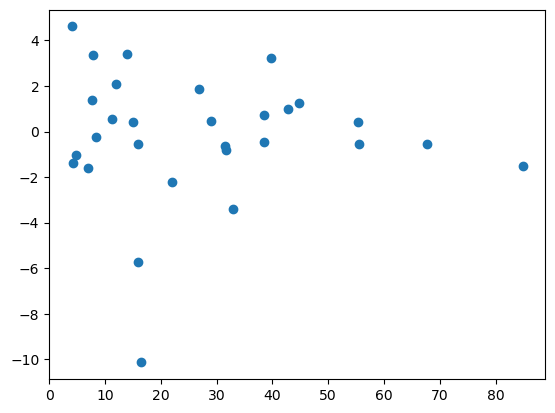

In [227]:
plt.scatter(tf_weight, bh_excess_ret)

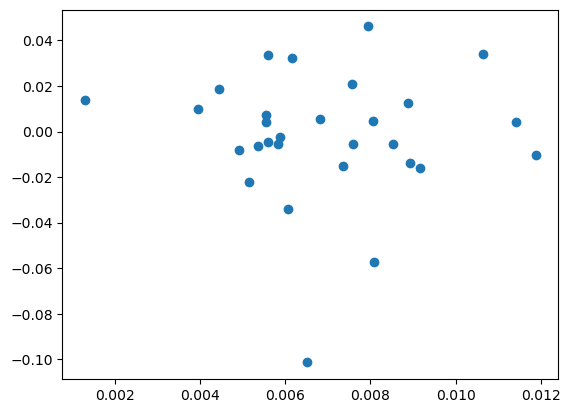

In [217]:
plt.scatter(pro_weight, bh_excess_ret)

### Linear Regression Model

In [228]:
# tf.idf weight being independent variable with an intercept
X = sm.add_constant(tf_weight)
Y = bh_excess_ret
tf_est = sm.OLS(Y, X)
tf_est2 = tf_est.fit()
tf_est2.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                   0.04292
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.837
Time:                        21:26:39   Log-Likelihood:                -71.074
No. Observations:                  29   AIC:                             146.1
Df Residuals:                      27   BIC:                             148.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0557      0.903     -0.062      0.951      -1.909       1.797
x1            -0.0055      0.027     -0.207      0.837      -0.060       0.049
==============================================================================
Omnibus:                       18.833   Durbin-Watson:                   2.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.194
Skew:                          -1.489   Prob(JB):                     1.24e-06
Kurtosis:                       6.693   Cond. No.                         56.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [221]:
# tf.idf weight being independent variable with no intercept
X = tf_weight
tf_est = sm.OLS(Y, X)
tf_est2 = tf_est.fit()
tf_est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):             -0.029
Method:                 Least Squares   F-statistic:                             0.1909
Date:                Mon, 23 Sep 2024   Prob (F-statistic):                       0.666
Time:                        21:14:22   Log-Likelihood:                          62.474
No. Observations:                  29   AIC:                                     -122.9
Df Residuals:                      28   BIC:                                     -121.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6.852e-05      0.000     -0.437      0.666      -0.000       0.000
==============================================================================
Omnibus:                       19.019   Durbin-Watson:                   2.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.621
Skew:                          -1.502   Prob(JB):                     1.01e-06
Kurtosis:                       6.720   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
# proportional weight being independent variable with an intercept
X = sm.add_constant(pro_weight)
pro_est = sm.OLS(Y, X)
pro_est2 = pro_est.fit()
pro_est2.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                   0.02261
Date:                Mon, 23 Sep 2024   Prob (F-statistic):              0.882
Time:                        21:27:06   Log-Likelihood:                -71.084
No. Observations:                  29   AIC:                             146.2
Df Residuals:                      27   BIC:                             148.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0451      1.753      0.026      0.980      -3.551       3.641
x1           -36.2417    241.014     -0.150      0.882    -530.761     458.278
==============================================================================
Omnibus:                       18.047   Durbin-Watson:                   2.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.582
Skew:                          -1.427   Prob(JB):                     2.79e-06
Kurtosis:                       6.609   Cond. No.                         446.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [223]:
# proportional weight being independent variable with no intercept
X = pro_weight
pro_est = sm.OLS(Y, X)
pro_est2 = pro_est.fit()
pro_est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):             -0.029
Method:                 Least Squares   F-statistic:                             0.1730
Date:                Mon, 23 Sep 2024   Prob (F-statistic):                       0.681
Time:                        21:14:34   Log-Likelihood:                          62.465
No. Observations:                  29   AIC:                                     -122.9
Df Residuals:                      28   BIC:                                     -121.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3035      0.730     -0.416      0.681      -1.798       1.191
==============================================================================
Omnibus:                       18.040   Durbin-Watson:                   2.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.536
Skew:                          -1.427   Prob(JB):                     2.85e-06
Kurtosis:                       6.603   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""